# Site

For a given position, reference wind speed (WS<sub>ref</sub>) and wind direction (WD<sub>ref</sub>), `Site` provides the local wind condition in terms of wind speed (WS), wind direction (WD), turbulence intensity (TI) and the probability of each combination of wind direction and wind speed. Furthermore, `Site` is responsible for calculating the down-wind, cross-wind and vertical distance between wind turbines (which in non-flat terrain is different from the straight-line distances).

## Predefined example sites
PyWake contains a few predefined sites of different complexities:
- IEA37Site: `UniformSite` (fix wind speed (9.8m/s), predefined wind sector probability)
- Hornsrev1: `UniformWeibullSite` (weibull distributed wind speed, predefined wind sector propability, uniform wind a over flat wind area)
- ParqueFicticioSite: `WaspGridSite` (Position-dependent weibull distributed wind speed and sector probability. Terrain following distances over non-flat terrain). Loaded from a set of *.grd files exported from WAsP

In [1]:
# Install PyWake if needed
try:
    import py_wake
except ModuleNotFoundError:
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake.git

In [2]:
from py_wake.examples.data.hornsrev1 import Hornsrev1Site
from py_wake.examples.data.iea37 import IEA37Site
from py_wake.examples.data.ParqueFicticio import ParqueFicticioSite
import numpy as np
import matplotlib.pyplot as plt

sites = {"IEA37": IEA37Site(n_wt=16), 
         "Hornsrev1": Hornsrev1Site(), 
         "ParqueFicticio": ParqueFicticioSite()}

## Define your own site
You can define your own site using one of the `Site` classes:

- [UniformWeibullSite](#UniformWeibullSite): Site with uniform sector-dependent weibull distributed wind speed
- [WaspGridSite](#WaspGridSite): Site with gridded non-uniform inflow based on *.grd files exported from WAsP
- [XRSite](#XRSite): The flexible general base class behind all Sites


### UniformWeibullSite

In [3]:
from py_wake.site import UniformWeibullSite
site = UniformWeibullSite(p_wd = [.20,.25,.35,.25], # sector frequencies
                          a = [9.176929,  9.782334,  9.531809,  9.909545], # Weibull scale parameter
                          k = [2.392578, 2.447266, 2.412109, 2.591797], # Weibull shape parameter
                          ti = 0.1 # turbulence intensity, optional (not needed in all cases)
                         )

### WaspGridSite

In [4]:
from py_wake.site import WaspGridSite
from py_wake.examples.data.ParqueFicticio import ParqueFicticio_path
site = WaspGridSite.from_wasp_grd(ParqueFicticio_path)

### XRSite

`XRSite(ds, initial_position=None, interp_method='linear', shear=None, distance=StraightDistance(), default_ws=np.arange(3, 26), bounds='check')`

The `XRSite` is the most general and flexible `Site`. 


**Input arguments**

- `ds`, xarray.Dataset
    - dataset with some required and optional data variables
    - Required data variables:
        - `P`: probability of flow case(s)
    
    or

        - `Weibull_A`: Weibull scale parameter(s)
        - `Weibull_k`: Weibull shape parameter(s)
        - `Sector_frequency`: Probability of each wind direction sector

    - Optional data variables:

        - `WS`: Wind speed, if not present, the reference wind speed `ws` is used
        - `Speedup`: Factor multiplied to the wind speed
        - `Turning`: Wind direction turning
        - `TI`: Turbulence intensity
        - xxx: Custom variables needed by the wind turbines to compute power, ct or loads

    - Each data variable may be constant or depend on any combination of:

        - `ws` : Reference wind speed
        - `wd`: Refernce wind direction
        - `i`: Wind turbine position (one position per wind turbine)
        - `x`,`y`: Gridded 2d position
        - `x`,`y`,`h`: Gridded 3d position
        - `time`: Time

    
    
- `initial_position`, array_like, shape=(#wt, 2), optional
    - wt positions (x,y)

- `interp_method`, {'linear', 'nearest'}, optional
    - interpolation method
- `shear`, function or Shear object, optional
    - Map wind speed, WS from direction, wd to wind speed at height, h: f(WS, wd, h) -> WS_z
    - See py_wake.site.shear
- `distance`, Distance object, optional
    - Calculate distance between wt or points. Default is straight line distance
- `default_ws`, number or array_like, optional
    - Default wind speeds
- `bounds`, {'check', 'limit', 'ignore'}, optional
    - Specifies how to handle out of bounds interpolation:

        - `check`: bounds check is performed. An error is raised if interpolation point outside area
        - `limit`: interpolation points are forced inside the area
        - `ignore`: Faster option with no check. Use this option if data is guaranteed to be inside the area



#### Examples


In [5]:
from py_wake.site import XRSite
from py_wake.site.shear import PowerShear
import xarray as xr
import numpy as np
from py_wake.utils import weibull
from numpy import newaxis as na

f = [0.036, 0.039, 0.052, 0.07, 0.084, 0.064, 0.086, 0.118, 0.152, 0.147, 0.1, 0.052]
A = [9.177, 9.782, 9.532, 9.91, 10.043, 9.594, 9.584, 10.515, 11.399, 11.687, 11.637, 10.088]
k = [2.393, 2.447, 2.412, 2.592, 2.756, 2.596, 2.584, 2.549, 2.471, 2.607, 2.627, 2.326]
wd = np.linspace(0, 360, len(f), endpoint=False)
ti = .1

# Site with constant wind speed, sector frequency, constant turbulence intensity and power shear
uniform_site = XRSite(
    ds=xr.Dataset(data_vars={'WS': 10, 'P': ('wd', f), 'TI': ti},
                  coords={'wd': wd}),
    shear=PowerShear(h_ref=100, alpha=.2))

# Site with wind direction dependent weibull distributed wind speed
uniform_weibull_site = XRSite(
    ds=xr.Dataset(data_vars={'Sector_frequency': ('wd', f), 'Weibull_A': ('wd', A), 'Weibull_k': ('wd', k), 'TI': ti},
                  coords={'wd': wd}))


# Site with a speedup and a turning value per WT
x_i, y_i = np.arange(5) * 100, np.zeros(5)  # WT positions
complex_fixed_pos_site = XRSite(
    ds=xr.Dataset(
        data_vars={'Speedup': ('i', np.arange(.8, 1.3, .1)),
                   'Turning': ('i', np.arange(-2, 3)),
                   'P': ('wd', f)},
        coords={'i': np.arange(5), 'wd': wd}),
    initial_position=np.array([x_i, y_i]).T)

# Site with gridded speedup information
complex_grid_site = XRSite(
    ds=xr.Dataset(
        data_vars={'Speedup': (['x', 'y'], np.arange(.8, 1.4, .1).reshape((3, 2))),
                   'P': ('wd', f)},
        coords={'x': [0, 500, 1000], 'y': [0, 500], 'wd': wd}))

# Site with ws dependent speedup and wd- and ws distributed probability
P_ws = weibull.cdf(np.array([3, 5, 7, 9, 11, 13]), 10, 2) - weibull.cdf(np.array([0, 3, 5, 7, 9, 11]), 10, 2)
P_wd_ws = P_ws[na, :] * np.array(f)[:, na]
complex_ws_site = XRSite(
    ds=xr.Dataset(
        data_vars={'Speedup': (['ws'], np.arange(.8, 1.4, .1)),
                   'P': (('wd', 'ws'), P_wd_ws), 'TI': ti},
        coords={'ws': [1.5, 4, 6, 8, 10, 12], 'wd': wd}))

### Local wind
The method `local_wind` returns a `LocalWind`-xarray dataset with a few additional methods:

In [6]:
localWinds = {name: site.local_wind(x_i=site.initial_position[:,0], # x position
                                    y_i = site.initial_position[:,1], # y position
                                    h_i=site.initial_position[:,0]*0+70, # height
                              ws=None, # defaults to 3,4,..,25
                              wd=None, # defaults to 0,1,...,360
                              ) for name, site in sites.items()}

`LocalWind` objects have some coordinates:

- i: Point number. Points can be wind turbine position or just points in a flow map
- wd: Ambient reference wind direction
- ws: Ambient reference wind speed
- x,y,h: position and height of points

and data variables:

- WD: Local wind direction
- WS: Local wind speed
- TI: Local turbulence intensity
- P: Probability of flow case (wind direction and wind speed)

The `IEA37` site has 16 wind turbines on a uniform site with a fixed wind speed of 9.8 m/s and the data variables therefore only depends on wind direction. 

In [7]:
localWinds['IEA37']

<xarray.LocalWind>
Dimensions:   (i: 16, wd: 360, ws: 1)
Coordinates:
  * ws        (ws) float64 9.8
  * wd        (wd) int32 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
  * i         (i) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
    x         (i) float64 0.0 650.0 200.9 -525.9 ... -401.7 401.7 1.052e+03
    y         (i) float64 0.0 0.0 618.2 382.1 ... -1.236e+03 -1.236e+03 -764.1
    h         (i) float64 70.0 70.0 70.0 70.0 70.0 ... 70.0 70.0 70.0 70.0 70.0
Data variables:
    WS        (ws) float64 9.8
    WD        (wd) int32 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
    TI        float64 0.075
    ws_lower  (ws) float64 9.3
    ws_upper  (ws) float64 10.3
    P         (wd) float64 0.001111 0.001111 0.001111 ... 0.001111 0.001111
Attributes:
    wd_bin_size:  1

The `Hornsrev1` site has 80 wind turbines on a uniform site and the data variables therefore depends on wind direction and wind speed.

In [8]:
localWinds['Hornsrev1']

<xarray.LocalWind>
Dimensions:           (i: 80, wd: 360, ws: 23)
Coordinates:
  * ws                (ws) int32 3 4 5 6 7 8 9 10 11 ... 18 19 20 21 22 23 24 25
  * wd                (wd) int32 0 1 2 3 4 5 6 7 ... 353 354 355 356 357 358 359
  * i                 (i) int32 0 1 2 3 4 5 6 7 8 ... 71 72 73 74 75 76 77 78 79
    x                 (i) float64 4.24e+05 4.24e+05 ... 4.294e+05 4.295e+05
    y                 (i) float64 6.151e+06 6.151e+06 ... 6.148e+06 6.148e+06
    h                 (i) float64 70.0 70.0 70.0 70.0 ... 70.0 70.0 70.0 70.0
Data variables:
    WS                (ws) int32 3 4 5 6 7 8 9 10 11 ... 18 19 20 21 22 23 24 25
    WD                (wd) int32 0 1 2 3 4 5 6 7 ... 353 354 355 356 357 358 359
    TI                float64 0.1
    ws_lower          (ws) float64 2.5 3.5 4.5 5.5 6.5 ... 21.5 22.5 23.5 24.5
    ws_upper          (ws) float64 3.5 4.5 5.5 6.5 7.5 ... 22.5 23.5 24.5 25.5
    Weibull_A         (wd) float64 9.177 9.177 9.177 9.177 ... 9.177 9.177 9.177
    Weibull_k         (wd) float64 2.393 2.393 2.393 2.393 ... 2.393 2.393 2.393
    Sector_frequency  (wd) float64 0.001199 0.001199 ... 0.001199 0.001199
    P                 (wd, ws) float64 6.147e-05 8.559e-05 ... 2.193e-08
Attributes:
    wd_bin_size:  1

Finally, the `ParqueFicticio` site has 8 turbines in a complex terrain and the data variables therefore dependents on both wind direction, wind speed and position

In [9]:
localWinds['ParqueFicticio']

<xarray.LocalWind>
Dimensions:           (i: 8, wd: 360, ws: 23)
Coordinates:
  * i                 (i) int32 0 1 2 3 4 5 6 7
  * wd                (wd) int32 0 1 2 3 4 5 6 7 ... 353 354 355 356 357 358 359
  * ws                (ws) int32 3 4 5 6 7 8 9 10 11 ... 18 19 20 21 22 23 24 25
    x                 (i) float64 2.637e+05 2.639e+05 ... 2.64e+05 2.639e+05
    y                 (i) float64 6.507e+06 6.506e+06 ... 6.505e+06 6.505e+06
    h                 (i) float64 70.0 70.0 70.0 70.0 70.0 70.0 70.0 70.0
Data variables:
    WS                (i, wd, ws) float64 3.785 5.046 6.308 ... 23.61 24.59
    WD                (i, wd) float64 9.367 10.34 11.32 ... 355.2 356.5 357.8
    ws_lower          (i, wd, ws) float64 3.154 4.415 5.677 ... 22.13 23.12 24.1
    ws_upper          (i, wd, ws) float64 4.415 5.677 6.939 ... 23.12 24.1 25.09
    Weibull_A         (i, wd) float64 5.363 5.365 5.368 5.37 ... 4.382 4.341 4.3
    Weibull_k         (i, wd) float64 1.807 1.815 1.822 ... 1.827 1.835 1.842
    Sector_frequency  (i, wd) float64 0.001768 0.001752 ... 0.001512 0.001479
    P                 (i, wd, ws) float64 0.0003305 0.0002909 ... 5.015e-14
    TI                (i, wd, ws) float64 0.2759 0.2326 0.2066 ... 0.1616 0.1605
Attributes:
    wd_bin_size:  1

Wind speeds at the wind turbines for reference wind speed of 3m/s (k=0):

- `IEA37`: Constant wind speed of 9.8m/s
- `Hornsrev1`: Constant wind speed over the site, 3 m/s
- `ParqueFicticio`: Winds speed depends on both wind direction and position

In [10]:
for name, lw in localWinds.items():
    print (name)
    print (lw.WS.isel(ws=0)) #[:8,0,0])
    print ("="*100)

IEA37
<xarray.DataArray 'WS' ()>
array(9.8)
Coordinates:
    ws       float64 9.8
Attributes:
    Description:  Local free-stream wind speed [m/s]
Hornsrev1
<xarray.DataArray 'WS' ()>
array(3)
Coordinates:
    ws       int32 3
Attributes:
    Description:  Local free-stream wind speed [m/s]
ParqueFicticio
<xarray.DataArray 'WS' (i: 8, wd: 360)>
array([[3.78471012, 3.80282588, 3.82094165, ..., 3.73730114, 3.75310413,
        3.76890713],
       [3.95569235, 3.97160588, 3.98751942, ..., 3.9194794 , 3.93155038,
        3.94362137],
       [3.54177811, 3.56318035, 3.5845826 , ..., 3.53682328, 3.53847489,
        3.5401265 ],
       ...,
       [3.38782152, 3.39601996, 3.4042184 , ..., 3.41634561, 3.40683758,
        3.39732955],
       [2.90165596, 2.90889396, 2.91613196, ..., 2.93079949, 2.92108498,
        2.91137047],
       [2.93723526, 2.94254094, 2.94784663, ..., 2.97948279, 2.96540028,
        2.95131777]])
Coordinates:
  * i        (i) int32 0 1 2 3 4 5 6 7
  * wd       (wd) int32 

The ParqueFicticio site models variations within the site, i.e. the local wind speed varies over the area

(262878.0, 264778.0, 6504714.0, 6506614.0)

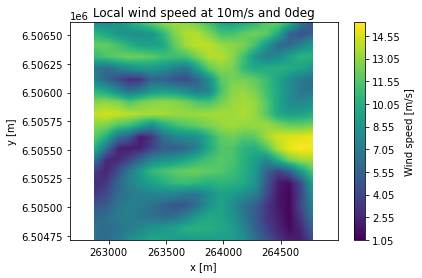

In [11]:
s = sites["ParqueFicticio"]
x = np.linspace(262878,264778,300)
y = np.linspace(6504714,6506614,300)
X,Y = np.meshgrid(x,y)
lw = s.local_wind(X.flatten(),Y.flatten(),30, ws=[10],wd=[0])
Z = lw.WS_ilk.reshape(X.shape)
c = plt.contourf(X,Y,Z, levels=100)
plt.colorbar(c,label='Wind speed [m/s]')
plt.title("Local wind speed at 10m/s and 0deg")
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.axis('equal')

### Distance
For the `IEA37Site` and the `Hornsrev1` the distances between points are the straight line distances, as these site types are flat.

For the ParqueFicticioSite, on the other hand, the down-wind distance is larger as it follows the non-flat terrain.

In [12]:
wd = [0, 30,90] # wind direction at source

for name, site in sites.items():
    print ("------- %s -------"%name)
    wt_x, wt_y = site.initial_position[0]
    site.distance.setup(src_x_i=[wt_x, wt_x], src_y_i=[wt_y, wt_y-1000], src_h_i=[70,90]) # wt2 1000m to the south)
    dw_ijl, cw_ijl, dh_ijl = site.distance(wd_il=[wd], src_idx=[0], dst_idx=[1])
    

    print ('Wind direction: \t\t%d deg\t\t%d deg\t\t%d deg'%tuple(wd))
    print ('Down wind distance [m]: \t%.1f\t\t%.1f\t\t%.1f'%tuple(dw_ijl[0,0,:]))
    print ('Cross wind distance [m]: \t%.1f\t\t%.1f\t\t%.1f'%tuple(cw_ijl[0,0,:]))
    print ('Height difference [m]: \t\t%.1f\t\t%.1f\t\t%.1f'%tuple(dh_ijl[0,0,:]))
    print()
    

------- IEA37 -------
Wind direction: 		0 deg		30 deg		90 deg
Down wind distance [m]: 	1000.0		866.0		0.0
Cross wind distance [m]: 	0.0		500.0		1000.0
Height difference [m]: 		20.0		20.0		20.0

------- Hornsrev1 -------
Wind direction: 		0 deg		30 deg		90 deg
Down wind distance [m]: 	1000.0		866.0		0.0
Cross wind distance [m]: 	0.0		500.0		1000.0
Height difference [m]: 		20.0		20.0		20.0

------- ParqueFicticio -------
Wind direction: 		0 deg		30 deg		90 deg
Down wind distance [m]: 	1023.6		886.5		-0.0
Cross wind distance [m]: 	0.0		500.0		1000.0
Height difference [m]: 		20.0		20.0		20.0



### Distribution plots

Site has a few plot function to visualize its properties

In [13]:
import matplotlib.pyplot as plt
site = sites['Hornsrev1']

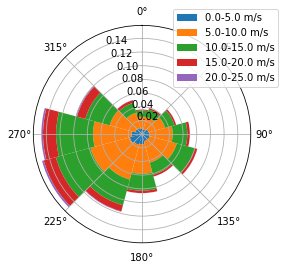

In [14]:
_ = site.plot_wd_distribution(n_wd=12, ws_bins=[0,5,10,15,20,25])

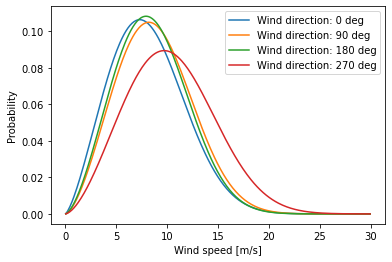

In [15]:
_ = site.plot_ws_distribution(wd=[0,90,180,270])

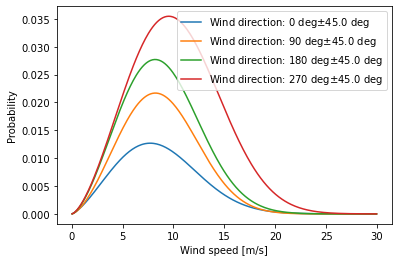

In [16]:
_ = site.plot_ws_distribution(wd=[0,90,180,270], include_wd_distribution=True)